In [38]:
%matplotlib inline
import numpy
from sys import path
# path.append('%s/work/fourier_quad/'%my_home)
path.append("/home/hkli/work/mylib")
from Fourier_Quad import Fourier_Quad
import matplotlib.pyplot as plt
from astropy.io import fits
import h5py
from plot_tool import Image_Plot
import tool_box
from scipy import signal

/mnt/ddnfs/data_users/hkli/selection_bias/paper_data/galsim_dimmer
/mnt/ddnfs/data_users/hkli/selection_bias/paper_data/galsim_dimmer/result/data/sex2_1.5/Rfacotr_3.hdf5
/mnt/ddnfs/data_users/hkli/selection_bias/paper_data/galsim_dimmer/result/data/sex2_1.5/mask_3.hdf5
/mnt/ddnfs/data_users/hkli/selection_bias/paper_data/galsim_dimmer/result/data/sex2_1.5/sex_3.hdf5
Source area: [  0.  29.  46. ...,  78.  52.  84.]
Neg R factor:  0
Mask : 9348609
Overlap: 0
Galaxy label of Neg R factor: []
Area of Neg R factor: []


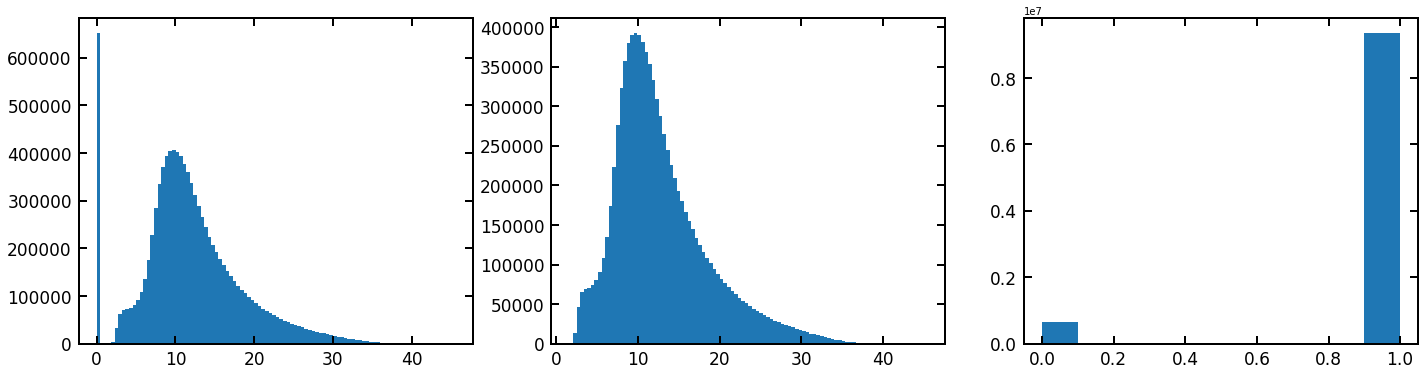

[]


In [56]:
stamp_size = 64
fq = Fourier_Quad(stamp_size,123)

src = "galsim_dimmer"
shear_tag = 3
sex_filter = "sex2_1.5"

total_path = "/mnt/ddnfs/data_users/hkli/selection_bias/paper_data/%s"%src

rfactor = "Rfacotr_%d.hdf5"%shear_tag
mask = "mask_%d.hdf5"%shear_tag
sex_detection = "sex_%d.hdf5"%shear_tag

r_path = "%s/result/data/%s/%s"%(total_path,sex_filter, rfactor)
mask_path = "%s/result/data/%s/%s"%(total_path,sex_filter, mask)
area_path = "%s/result/data/%s/%s"%(total_path,sex_filter, sex_detection)

print(total_path)
print(r_path)
print(mask_path)
print(area_path)

h5f = h5py.File(r_path,"r")
rfactor = h5f["/data"].value[:,0]
h5f.close()

h5f = h5py.File(mask_path,"r")
mask = h5f["/data"].value[:,0]
h5f.close()

h5f = h5py.File(area_path,"r")
area = h5f["/data"].value[:,3]
print("Source area:",area)
h5f.close()

source_num = mask.shape[0]
labels = numpy.arange(0,source_num)


idx_r = rfactor < 0

idx_mask = mask > 0

idx = idx_mask& idx_r

print("Neg R factor: ", idx_r.sum())
print("Mask :",idx_mask.sum())
print("Overlap:",idx.sum())

print("Galaxy label of Neg R factor:",labels[idx_r])
print("Area of Neg R factor:",area[idx_r])


img = Image_Plot()
img.subplots(1,3)

img.axs[0][0].hist(rfactor,100)
img.axs[0][1].hist(rfactor[idx_mask],100)
img.axs[0][2].hist(mask,10)
img.show_img()
print(labels[idx_r])

Test galaxy 197 is the 197'th galaxy in gal_chip_0000.fits with area: 48
Mask:  1
Test img_path: /mnt/ddnfs/data_users/hkli/selection_bias/paper_data/galsim_dimmer/3/gal_chip_0000.fits
R factor: 16.33560, Eff_radius from area: 3.90882
Image Sum 21032.1
Rfactor cpp: 16.33560, py: 16.33560


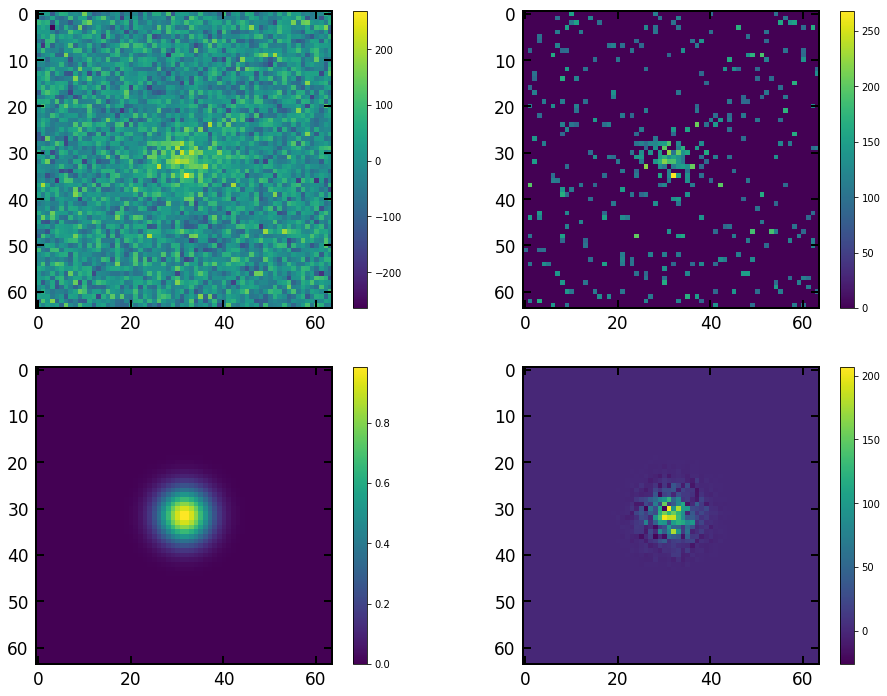

In [58]:
test_id = 197
m,n = divmod(test_id,10000)

if mask[test_id] > 0:

    rfactor_test,eff_r_test = rfactor[test_id],numpy.sqrt(area[test_id]/numpy.pi)

    print("Test galaxy %d is the %d'th galaxy in gal_chip_%04d.fits with area: %d"%(test_id, n, m, area[test_id]))
    print("Mask: ",mask[test_id])
    test_img_path = "%s/%d/gal_chip_%04d.fits"%(total_path, shear_tag,m)
    print("Test img_path:",test_img_path)
    print("R factor: %.5f, Eff_radius from area: %.5f"%(rfactor_test,eff_r_test))

    gal_test = fq.segment(fits.open(test_img_path)[0].data)[n]
    gal_quad,weight, gal_img_w = tool_box.get_quad(gal_test,stamp_size,eff_r_test)

    print("Image Sum",gal_test.sum())
    print("Rfactor cpp: %.5f, py: %.5f"%(rfactor_test,gal_quad))

    img = Image_Plot()
    img.subplots(2,2)
    idx = gal_test < 90
    fig = img.axs[0][0].imshow(gal_test)
    plt.colorbar(fig,ax=img.axs[0][0])
    gal_mask = gal_test.copy()
    gal_mask[idx] = 0 
    fig = img.axs[0][1].imshow(gal_mask)
    plt.colorbar(fig,ax=img.axs[0][1])

    fig = img.axs[1][0].imshow(weight)
    plt.colorbar(fig,ax=img.axs[1][0])
    fig = img.axs[1][1].imshow(gal_img_w)
    plt.colorbar(fig,ax=img.axs[1][1])

    img.show_img()
else:
    print("Non-detected")

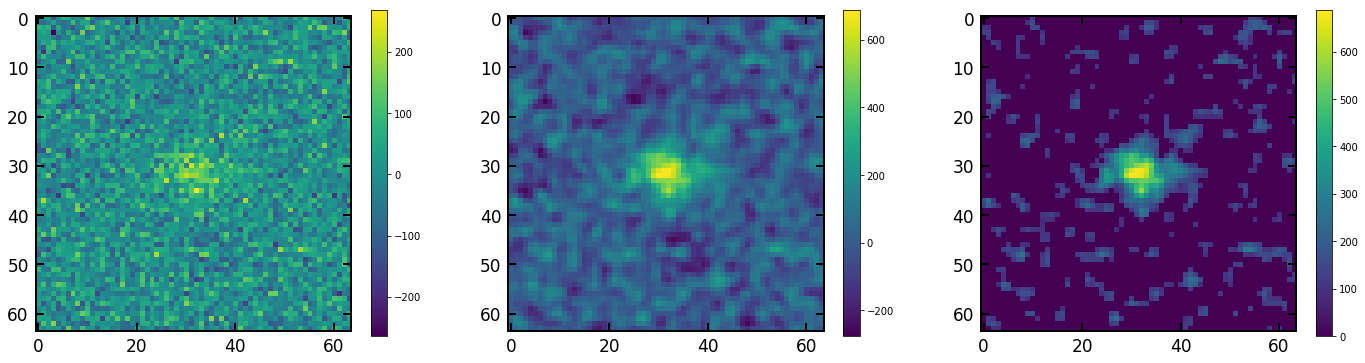

In [59]:
hdu = fits.PrimaryHDU(gal_test)
hdu.writeto("/home/hkli/work/sex/gal_test.fits",overwrite=True)

conv = numpy.array([[0.006319, 0.040599, 0.075183, 0.040599, 0.006319],                                                                                                                      
                      [0.040599, 0.260856, 0.483068, 0.260856, 0.040599],
                      [0.075183, 0.483068, 0.894573, 0.483068, 0.075183],
                      [0.040599, 0.260856, 0.483068, 0.260856, 0.040599],
                      [0.006319, 0.040599, 0.075183, 0.040599, 0.006319]])


gal_con = signal.convolve(gal_test,conv,mode="same")
img = Image_Plot()
img.subplots(1,3)

fig = img.axs[0][0].imshow(gal_test)
plt.colorbar(fig,ax=img.axs[0][0])
idx = gal_con < 90
gal_mask = gal_con.copy()
gal_mask[idx] = 0
fig = img.axs[0][1].imshow(gal_con)
plt.colorbar(fig,ax=img.axs[0][1])
fig = img.axs[0][2].imshow(gal_mask)
plt.colorbar(fig,ax=img.axs[0][2])
img.show_img()
    